In [2]:
%load_ext autoreload
%autoreload 2
import torch
import cv2
import numpy as np
from kornia.geometry import denormalize_pixel_coordinates
from torch.testing import assert_close
from courtvision.trackers import Tracker, StateIdx
import rerun as rr
from courtvision.geometry import (
    solve_for_camera_matrix,
    solve_for_projection_matrix,
    denormalize_points,
    corners_world_3d,
    solve_for_projection_matrix_v2,
)

In [3]:
a_front_left
b_front_right
c_back_left
d_back_right
e_left_near_serve_line
f_right_near_serve_line
g_left_far_serve_line
h_right_far_serve_line
i_center_line_far
j_net_line_left
k_center_line_near
l_net_line_right
m_top_front_left
n_top_front_right
o_top_back_left
p_top_back_right
q_top_net_line_left
r_top_net_line_right
s_top_net_center
t_center_center
u_topfence_front_left
v_topfence_front_right
w_topfence_back_left
x_topfence_back_right
y_top_center_left
z_top_center_right

['a_front_left',
 'b_front_right',
 'c_back_left',
 'd_back_right',
 'e_left_near_serve_line',
 'f_right_near_serve_line',
 'g_left_far_serve_line',
 'h_right_far_serve_line',
 'i_center_line_far',
 'j_net_line_left',
 'k_center_line_near',
 'l_net_line_right',
 'm_top_front_left',
 'n_top_front_right',
 'o_top_back_left',
 'p_top_back_right',
 'q_top_net_line_left',
 'r_top_net_line_right',
 's_top_net_center',
 't_center_center',
 'u_topfence_front_left',
 'v_topfence_front_right',
 'w_topfence_back_left',
 'x_topfence_back_right',
 'y_top_center_left',
 'z_top_center_right']

In [363]:
from courtvision.geometry import corners_world_3d, convert_corners_to_coords
from courtvision.vis import draw_points, points_to_heat_map
from courtvision.geometry import get_corners_image, get_corners_verital_plane_on_image

pose_points_to_use = [
    # "a_front_left",
    # "b_front_right",
    #  'c_back_left',
    #  'd_back_right',
    #  'e_left_near_serve_line',
    #  'f_right_near_serve_line',
    #  'g_left_far_serve_line',
    #  'h_right_far_serve_line',
    #  'i_center_line_far',
    #  'j_net_line_left',
    #  'k_center_line_near',
    #  'l_net_line_right',
    "m_top_front_left",
    "n_top_front_right",
    "o_top_back_left",
    "p_top_back_right",
]

calibration_poibts_to_use = [
    "a_front_left",
    "b_front_right",
    "c_back_left",
    "d_back_right",
    "e_left_near_serve_line",
    "f_right_near_serve_line",
    "g_left_far_serve_line",
    "h_right_far_serve_line",
    "i_center_line_far",
    "j_net_line_left",
    "k_center_line_near",
    "l_net_line_right",
]

corners_world_3d_calib = corners_world_3d.copy()
corners_world_3d_pose = corners_world_3d.copy()

corners_image_n = get_corners_image("curated_001/curated_001_frame_0001")
corners_image_other = get_corners_verital_plane_on_image(
    "curated_001/curated_001_frame_0001", plane="both"
)
corners_image_n.update(corners_image_other)

corners_image_n_calib = corners_image_n.copy()
corners_image_n_pose = corners_image_n.copy()


def remove_points(data_points, use_points):
    for k in list(data_points.keys()):
        if k not in use_points:
            print(f"removing {k}")
            data_points.pop(k)
    return data_points


corners_world_3d_calib = remove_points(
    corners_world_3d_calib, calibration_poibts_to_use
)
corners_image_n_calib = remove_points(corners_image_n_calib, calibration_poibts_to_use)

corners_world_3d_pose = remove_points(corners_world_3d_pose, pose_points_to_use)
corners_image_n_pose = remove_points(corners_image_n_pose, pose_points_to_use)

assert len(set(corners_world_3d_calib.keys()) - set(corners_image_n_calib.keys())) == 0
assert len(set(corners_image_n_calib.keys()) - set(corners_world_3d_calib.keys())) == 0

assert len(set(corners_world_3d_pose.keys()) - set(corners_image_n_pose.keys())) == 0
assert len(set(corners_image_n_pose.keys()) - set(corners_world_3d_pose.keys())) == 0
assert all(
    [
        world_pose == image_pose
        for world_pose, image_pose in zip(
            corners_world_3d_pose.keys(), corners_image_n_pose.keys(), strict=True
        )
    ]
)
assert len(corners_image_n_pose) == len(corners_world_3d_pose)

removing m_top_front_left
removing n_top_front_right
removing o_top_back_left
removing p_top_back_right
removing m_top_front_left
removing n_top_front_right
removing o_top_back_left
removing p_top_back_right
removing q_top_net_line_left
removing r_top_net_line_right
removing a_front_left
removing b_front_right
removing c_back_left
removing d_back_right
removing e_left_near_serve_line
removing f_right_near_serve_line
removing g_left_far_serve_line
removing h_right_far_serve_line
removing i_center_line_far
removing j_net_line_left
removing k_center_line_near
removing l_net_line_right
removing a_front_left
removing b_front_right
removing c_back_left
removing d_back_right
removing e_left_near_serve_line
removing f_right_near_serve_line
removing g_left_far_serve_line
removing h_right_far_serve_line
removing i_center_line_far
removing j_net_line_left
removing k_center_line_near
removing l_net_line_right
removing q_top_net_line_left
removing r_top_net_line_right


In [364]:
corners_world_3d_pose

{'m_top_front_left': (0.0, 0.0, 300.0),
 'n_top_front_right': (1000.0, 0, 300.0),
 'o_top_back_left': (0.0, 2000.0, 300.0),
 'p_top_back_right': (1000.0, 2000.0, 300.0)}

In [365]:
image_size = (1280, 720)
world_points_calib = torch.tensor(
    convert_corners_to_coords(corners_world_3d_calib), dtype=torch.float64
)

world_points_pose = torch.tensor(
    convert_corners_to_coords(corners_world_3d_pose), dtype=torch.float64
)
# converto from left handed to right handed coordinate system
# world_points_pose[:,1] = -world_points_pose[:,1]

image_points_calib = torch.tensor(
    denormalize_points(
        corners_image_n_calib, width=image_size[0], height=image_size[1]
    ),
    dtype=torch.float64,
)
image_points_pose = torch.tensor(
    denormalize_points(corners_image_n_pose, width=image_size[0], height=image_size[1]),
    dtype=torch.float64,
)
print(f"{image_points_pose.shape=}")

start_calib_idx = 0
end_calib_idx = 6
camera_matrix, dist_coeffs, reproj_error = solve_for_camera_matrix(
    world_points=world_points_calib[start_calib_idx:end_calib_idx],
    image_points=image_points_calib[start_calib_idx:end_calib_idx],
    image_size=image_size,
    repo_erro_threshold=310.0,
)

print(f"{world_points_pose.numpy().shape=}")
print(f"{image_points_pose.numpy().shape=}")
start_pose_idx = 0
end_pose_idx = 4
projection_matrix, rvec, tvec, reprojected_image_points = solve_for_projection_matrix(
    world_points=world_points_pose.numpy()[start_pose_idx:end_pose_idx],
    image_points=image_points_pose.numpy()[start_pose_idx:end_pose_idx],
    camera_matrix=camera_matrix,
    dist_coeffs=dist_coeffs,
    in_object_coordinate_frame=True,
)

print(f"{np.linalg.norm(tvec)=}")

image_points_pose.shape=torch.Size([4, 2])
repo_erro=0.0001749645361528768
world_points_pose.numpy().shape=(4, 3)
image_points_pose.numpy().shape=(4, 2)
reprojection_error=18.61625498225272
np.linalg.norm(tvec)=935.4166259906056


In [366]:
from courtvision.geometry import transfrom_points

# reprojected_again = transfrom_points(
#     world_points_pose.numpy()[start_pose_idx:end_pose_idx],
#     projection_matrix,
#     tvec,

# )
cv2.transform
reproject_all, _ = cv2.projectPoints(
    world_points_pose.numpy(), rvec, tvec, camera_matrix, dist_coeffs
)
reproject_all = reproject_all.reshape(-1, 2)
reprojected_image_points.shape, reproject_all.shape, world_points_pose.numpy().shape, world_points_pose, reproject_all, image_points_pose

((4, 2),
 (4, 2),
 (4, 3),
 tensor([[   0.,    0.,  300.],
         [1000.,    0.,  300.],
         [   0., 2000.,  300.],
         [1000., 2000.,  300.]], dtype=torch.float64),
 array([[ 111.95240188,  338.91577266],
        [1169.93723632,  350.1681233 ],
        [ 369.42977887,   82.91731771],
        [ 912.42636375,   82.67685026]]),
 tensor([[ 112.4038,  352.3828],
         [1170.1101,  351.7246],
         [ 392.6118,   62.6319],
         [ 891.6557,   62.9870]], dtype=torch.float64))

In [367]:
reproject_all

array([[ 111.95240188,  338.91577266],
       [1169.93723632,  350.1681233 ],
       [ 369.42977887,   82.91731771],
       [ 912.42636375,   82.67685026]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
4


(<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>,
 <Figure size 640x480 with 1 Axes>)

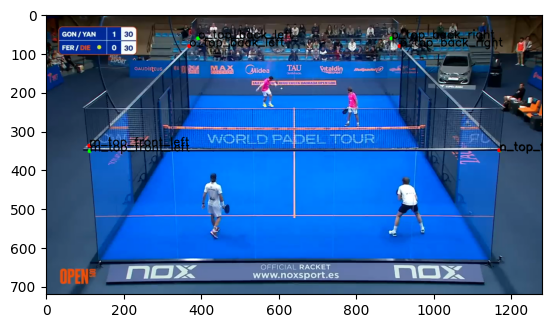

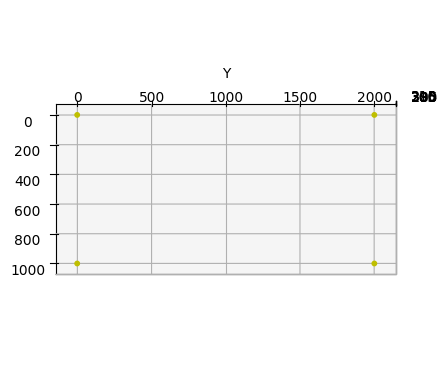

In [369]:
from kornia.utils.draw import draw_rectangle
from courtvision.vis import load_timg, plot_3d_points
import cv2


image = (
    load_timg(
        "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/curated_001_frame_0001.png"
    )
    .squeeze(0)
    .permute(1, 2, 0)
    .numpy()
)
# cv2.circle(image, tuple(image_points[1].numpy().astype(int)), 5, (255, 0, 0), -1)
# image = draw_rectangle(image=image, rectangle=image_points[:2].reshape(-1, 4).unsqueeze(0), fill=True, color=torch.tensor([1, 1, 255])).squeeze(0).permute(1, 2, 0)
import matplotlib.pyplot as plt

print(len(reproject_all))
print(len(image_points_pose))
# pp=points_to_heat_map(corners_image_n, height=image_size[1], width=image_size[0], normalised=True)
# draw_points(image=image, points=pp, color=(255, 0, 0), radius=5, thickness=-1)
draw_points(
    image=image,
    points=image_points_pose[:],
    color=(0, 255, 0),
    radius=5,
    thickness=-1,
    labels=pose_points_to_use,
)
draw_points(
    image=image,
    points=reproject_all,
    color=(255, 0, 0),
    radius=5,
    thickness=-1,
    labels=pose_points_to_use,
)
# print(f"{len(reprojected_image_points)}")
plt.imshow(image)
plot_3d_points(
    x=world_points_pose[:, 0].numpy(),
    y=world_points_pose[:, 1].numpy(),
    z=world_points_pose[:, 2].numpy(),
    # labels=list(corners_world_3d.keys())
)

In [270]:
points_2d_homogeneous = np.dot(projection_matrix, world_points_pose.T)
points_2d = (points_2d_homogeneous[:2] / points_2d_homogeneous[2]).T
points_2d

c

array([[            nan,             nan],
       [-1.01492535e+02, -6.93483675e-01],
       [ 3.96391236e-01, -5.65705476e+01],
       [ 3.97694150e+01, -7.81631687e+01],
       [ 3.96391236e-01, -5.65705476e+01],
       [-1.58501787e+02,  3.05710488e+01],
       [ 3.96391236e-01, -5.65705476e+01],
       [ 4.61068547e+01, -8.16386938e+01],
       [ 1.90641594e+01, -6.68081673e+01],
       [ 3.96391236e-01, -5.65705476e+01],
       [-3.60345194e+02,  1.41264305e+02],
       [ 1.28737340e+02, -1.26954207e+02],
       [ 9.73169086e-03,  1.77452331e-02],
       [-3.21833048e+00, -4.87387890e-03],
       [-4.19236191e-02,  7.57758914e+00],
       [-3.68389903e+00,  7.28066590e+00]])

In [290]:
from courtvision.geometry import transfrom_points, convert_points_to_homogeneous

# # Transform object points to camera frame
# objectPoints_camera = transfrom_points(
#     points=world_points_pose.numpy(), transformation_matrix=projection_matrix, tvec=tvec
# )
# print(objectPoints_camera.shape)
# # objectPoints_camera = np.array([objectPoints_camera[:,1],objectPoints_camera[:,0],objectPoints_camera[:,2]]).T
# # permuted_arr = np.array([arr[2], arr[1], arr[0]])
# #
# assert np.isclose(np.linalg.norm(objectPoints_camera[0]),  np.linalg.norm(tvec))
# print(len(objectPoints_camera))

# objectPoints_camera
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Compute inverse of rotation matrix
rotation_matrix_inv = np.linalg.inv(rotation_matrix)

# Compute negative of translation vector
tvec_neg = -tvec

# Transform world points to camera coordinate frame
objectPoints_camera = np.dot(
    rotation_matrix_inv, (world_points_pose.numpy() - tvec_neg.T).T
).T

# objectPoints_camera[:,2] = objectPoints_camera[:,2] * -1
objectPoints_camera[:, 1] = objectPoints_camera[:, 1] * -1
# objectPoints_camera[:,0] = objectPoints_camera[:,0] * -1
print(objectPoints_camera)

[[ -489.04239047   843.3928643   -875.42302097]
 [  510.8857331    836.38710583  -885.15271939]
 [ -475.37766464  2843.03138608  -910.90622107]
 [  524.55045894  2836.02562761  -920.63591949]
 [ -487.67591789  1043.35671648  -878.97134098]
 [  512.25220569  1036.35095801  -888.7010394 ]
 [ -476.74413722  2643.0675339   -907.35790106]
 [  523.18398635  2636.06177543  -917.08759948]
 [   23.21992457  2639.56465467  -912.22275027]
 [ -482.21002756  1843.21212519  -893.16462102]
 [   12.2881439   1039.85383724  -883.83619019]
 [  517.71809602  1836.20636672  -902.89431944]
 [ -491.99806045   838.09070989 -1175.36159997]
 [  507.93006313   831.08495143 -1185.09129839]
 [ -478.33333461  2837.72923167 -1210.84480007]
 [  521.59478896  2830.72347321 -1220.57449849]]


In [277]:
import rerun as rr

if False:
    rr.init("Blueprint demo")
    rr.start_web_viewer_server()
    rec = rr.memory_recording()
else:
    from random import randint
    import string

    dd = "".join(
        [
            string.ascii_letters[randint(0, len(string.ascii_letters) - 1)]
            for i in range(10)
        ]
    )
    rr.init(dd, spawn=True)
rr.set_time_sequence("frame_nr", 0)
i = 0

In [288]:
i = i + 1
print(i)
rr.set_time_sequence("frame_nr", i)
rr.log_view_coordinates("camera", up="+Z", right_handed=False, timeless=False)
# rr.log_view_coordinates("world",xyz="RFU", timeless=True)

# rr.log_rigid3(
#             "world/camera",
#             child_from_parent=(translation_xyz,quat_xyzw),

#             # xyz="RFD",  # X=Right, Y=Down, Z=Forward
#         )
# rr.log_transform3d("camera",
#                    transform=from_camera_to_world,
#                    from_parent=False,
#                    )

rr.log_pinhole(
    "camera/image",
    child_from_parent=camera_matrix,
    width=image_size[0],
    height=image_size[1],
    #   timeless=True,
)
img = cv2.imread(
    "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/curated_001_frame_0001.png"
)
print(img.shape)
img = cv2.resize(img, (1280, 720))
print(img.shape)
rr.log_image("camera/image", img)

# rr.log_points("world/camera/imgae",
#               positions=denormalize_pixel_coordinates(image_points,height=image_size[1],width=image_size[0]),
#               )
rr.log_point(
    "camera/origin",
    position=torch.tensor([0.0, 0.0, 0.0]),
    color=(1.0, 0.0, 0.0),
    radius=10.0,
)

rr.log_point(
    "camera/x",
    position=torch.tensor([20.0, 0.0, 0.0]),
    color=(1.0, 1.0, 0.0),
    radius=10.0,
)
rr.log_point(
    "camera/y",
    position=torch.tensor([0.0, 20.0, 0.0]),
    color=(1.0, 1.0, 0.0),
    radius=10.0,
)
rr.log_point(
    "camera/z",
    position=torch.tensor([0.0, 0.0, 20.0]),
    color=(1.0, 1.0, 0.0),
    radius=10.0,
)
rr.log_arrow(
    "camera/front_left_to_back_left",
    origin=objectPoints_camera[0],
    vector=objectPoints_camera[2] - objectPoints_camera[0],
    color=(0.0, 0.0, 1.0),
)
rr.log_arrow(
    "camera/front_right_to_back_right",
    origin=objectPoints_camera[1],
    vector=objectPoints_camera[3] - objectPoints_camera[1],
    color=(0.0, 0.0, 1.0),
)
rr.log_points(
    "camera/court_points",
    positions=objectPoints_camera[2:],
    colors=torch.tensor([1.0, 0.0, 0.0]),
    radii=100.0,
)
rr.log_points(
    "camera/court_points_front",
    positions=objectPoints_camera[:2],
    colors=torch.tensor([1.0, 1.0, 0.0]),
    radii=100.0,
)
rr.log_obb(
    "camera/court",
    half_size=(300.0, 1000.0, 500.0),
    position=(300.0, 1000.0, 500.0),
    stroke_width=3.0,
)


# rr.log_obb("world/court2",
#            half_size=(5000.0/2, 20000.0/2, 3000.0/2),
#            position=(2500.0, 1000.0, 1500.0),
# )
# rr.log_point("world/points_ball", position=torch.tensor([0.0, 0.0, 0.0]),color=(0.0, 0.0, 1.0), radius=10.0)
# # rr.log_points("world/court_points", positions=world_points, colors=torch.tensor([1.0, 0.0, 0.0]),radii=1000.0)
# rr.log_point("world/points_ball", position=torch.tensor([500.0, 1000.0, 300.0]),color=(0.0, 0.0, 1.0), radius=10.0)

6
(720, 1280, 3)
(720, 1280, 3)


In [ ]:
from kornia.geometry import RANSAC
import kornia


class SolvePnP(RANSAC):
    def __init__(
        self,
        model_type: str = "pose",
        inl_th: float = 2.0,
        batch_size: int = 2048,
        max_iter: int = 10,
        confidence: float = 0.99,
        max_lo_iters: int = 5,
    ):
        super().__init__()
        self.inl_th = inl_th
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.model_type = model_type
        self.confidence = confidence
        self.max_lo_iters = max_lo_iters
        self.model_type = model_type

        self.error_fn: Callable[..., Tensor]
        self.minimal_solver: Callable[..., Tensor]
        self.polisher_solver: Callable[..., Tensor]

        if model_type == "pose":
            self.error_fn = oneway_transfer_error
            self.minimal_solver = kornia.geometry.calibration.solve_pnp_dlt
            self.polisher_solver = kornia.geometry.calibration.solve_pnp_dlt
            self.minimal_sample_size = 4
        else:
            raise NotImplementedError(
                f"{model_type} is unknown. Try one of {self.supported_models}"
            )

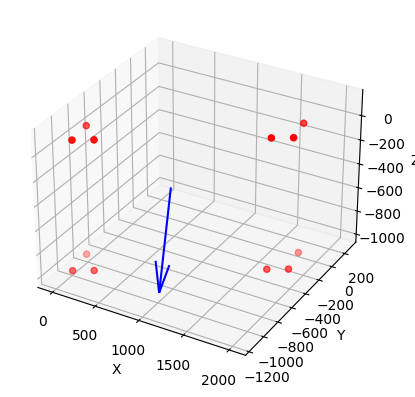

In [14]:
# %matplotlib notebook

import matplotlib.pyplot as plt

camera_points = objectPoints_camera
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot world points in green
# ax.scatter(world_points[:, 0], world_points[:, 1], world_points[:, 2], c='green')

# Plot camera points in red
ax.scatter(camera_points[:, 0], camera_points[:, 1], camera_points[:, 2], c="red")


camera_position = -tvec
# The camera orientation is the third column of the rotation matrix (or the third row, depending on the convention used).
camera_orientation = (
    projection_matrix[:, 2]
    if projection_matrix.shape[0] == 3
    else projection_matrix[2, :]
)

# Plot camera as an arrow
ax.quiver(
    camera_position[0],
    camera_position[1],
    camera_position[2],
    camera_orientation[2],
    camera_orientation[1],
    camera_orientation[0],
    length=1000.0,
    color="blue",
)

# Adding labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
# ax.view_init(elev=90, azim=0)
# Show the plot
plt.show()

In [27]:
tvec

array([[-2093.20904117],
       [ -644.60521486],
       [  650.60182588]])

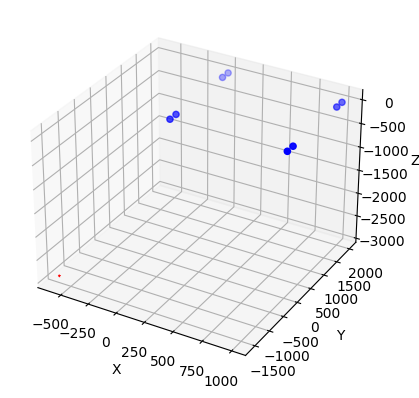

In [172]:
import matplotlib.pyplot as plt

# Transform object points
objectPoints = world_points.numpy()
objectPoints_transformed = objectPoints  # np.dot(projection_matrix[:3,:3], objectPoints.T).T + projection_matrix[:3,3]

# Get camera direction from rotation matrix
camera_direction = -projection_matrix[
    :, 2
]  # In OpenGL convention, camera is looking down the negative z-axis

# Create a new figure and add a 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the transformed object points
ax.scatter(
    objectPoints_transformed[:, 0],
    objectPoints_transformed[:, 1],
    objectPoints_transformed[:, 2],
    c="b",
    marker="o",
)

# Plot the camera location as a red arrow
ax.quiver(
    translation_xyz[0],
    translation_xyz[1],
    translation_xyz[2],
    camera_direction[0],
    camera_direction[1],
    camera_direction[2],
    color="r",
    length=100.5,
)

# Add labels to the axes
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [49]:
translation_xyz

array([ 5.02635904e+02, -2.13946340e+03,  1.71047864e+00])

In [29]:
# Define the 3D point in homogeneous coordinates
# P_hom = np.array([[X], [Y], [Z], [1]], dtype=np.float32)

# # Project the 3D point to the image plane using the projection matrix
# P_proj_hom = np.dot(P, P_hom)

# # Normalize the image coordinates
# P_proj = P_proj_hom[:2] / P_proj_hom[2]

# # Print the projected point on the image plane
# print("Projected point:", P_proj)

In [358]:
from PIL import Image, ImageDraw

# List of points describing the polygon
points = [
    [10.327358086068914, 88.10811571511495],
    [7.983608086068915, 48.10811571511493],
    [30.48360808606891, 8.5247823817816],
    [69.56886470655024, 8.486700443446004],
    [92.03125, 47.77777777777778],
    [89.84375, 88.33333333333333],
]

# Create a new blank image
image_width = 1280
image_height = 720
points = [
    (int(x_y[0] / 100 * image_width), int(x_y[1] / 100 * image_height))
    for x_y in points
]
# points.append(points[0])
print(points)

mask = Image.new("L", (image_width, image_height), color=0)
# img = Image.new("RGB", size, "# f9f9f9")
# img1 = ImageDraw.Draw(img)
# img1.polygon(xy, fill ="# eeeeff", outline ="blue")
# Create a drawing context
draw = ImageDraw.Draw(mask)

# Draw the polygon using the list of points
# draw.polygon([(10,10), (20,20), (30,30)], fill ="#eeeeff", outline ="blue")
draw.polygon(points, fill=255)

# Show the mask image
mask.save("mask.png")
mask.show()

[(132, 634), (102, 346), (390, 61), (890, 61), (1178, 344), (1150, 636)]


In [37]:
import torch
import kornia
from courtvision.geometry import corners_world_3d

#  REF https://ksimek.github.io/2013/08/13/intrinsic/
world_points = torch.tensor(
    convert_corners_to_coords(corners_world_3d), dtype=torch.float64
).unsqueeze(0)

img_points = torch.tensor(
    convert_corners_to_coords(corners_image), dtype=torch.float64
).unsqueeze(0)
# print(f"{img_points=}")
from kornia.geometry.conversions import (
    normalize_pixel_coordinates,
    denormalize_pixel_coordinates,
    normalize_pixel_coordinates3d,
)

img_points_N = normalize_pixel_coordinates(img_points, width=1280, height=720)
img_points_d = denormalize_pixel_coordinates(img_points_N, width=1280, height=720)
# print(f"{img_points_d=}")
fx = 1000
fy = 1000
cy = 720 / 2

cx = 1280 / 2


intrinsics = torch.tensor(
    [
        [
            [fx, 0.0, cx],
            [0.0, fy, cy],
            [0.0, 0.0, 1.0],
        ]
    ],
    dtype=torch.float64,
)

print(world_points.shape, img_points.shape, intrinsics.shape)
# torch.Size([1, 6, 3]) torch.Size([1, 6, 2]) torch.Size([1, 3, 3])
world_points_N = normalize_pixel_coordinates3d(
    world_points, depth=2000.0, height=300.0, width=1000.0
)
# Solve PnP
import cv2
import numpy as np

dist_coeffs = np.array([0, 0, 0, 0, 0], dtype=np.float32)

success, rvec, tvec = cv2.solvePnP(
    world_points.numpy(),
    img_points_N.numpy(),
    intrinsics.squeeze(0).numpy(),
    dist_coeffs,
    flags=cv2.SOLVEPNP_ITERATIVE,
    useExtrinsicGuess=False,
)
print(f"{success=}")
# Convert rotation vector to rotation matrix
rmat, _ = cv2.Rodrigues(rvec)

# Concatenate rotation matrix and translation vector to create a 3x4 transformation matrix
transformation_matrix = np.hstack((rmat, tvec))
print(f"{transformation_matrix=}")
#    {rvec=} {tvec=}")
pred_world_to_cam = kornia.geometry.solve_pnp_dlt(
    world_points_N, img_points_N, intrinsics, svd_eps=0.0000000001
)

# print(pred_world_to_cam.shape)
print(f"{pred_world_to_cam=}")
# torch.Size([1, 3, 4])

# pred_world_to_cam
# world_points_N

torch.Size([1, 16, 3]) torch.Size([1, 12, 2]) torch.Size([1, 3, 3])


error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/solvepnp.cpp:833: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPGeneric'


In [33]:
import numpy as np


def calculate_reprojection_error_using_projection_matrix(
    objpoints, imgpoints, projection_matrix
):
    mean_error = 0
    for i in range(len(objpoints)):
        # convert the object point to homogeneous coordinates
        objpoint_homogeneous = np.hstack((objpoints[i], 1))
        # project the object point
        imgpoint_projected_homogeneous = np.dot(projection_matrix, objpoint_homogeneous)
        # convert the projected point from homogeneous to cartesian coordinates
        imgpoint_projected = (
            imgpoint_projected_homogeneous[:2] / imgpoint_projected_homogeneous[2]
        )
        # calculate the error
        error = np.linalg.norm(imgpoints[i] - imgpoint_projected)
        mean_error += error
    return mean_error / len(objpoints)


print(
    calculate_reprojection_error_using_projection_matrix(
        world_points_N.squeeze(0).numpy(),
        img_points_N.squeeze(0).numpy(),
        pred_world_to_cam.squeeze(0).numpy(),
    )
)
calculate_reprojection_error_using_projection_matrix(
    world_points_N.squeeze(0).numpy(),
    img_points_N.squeeze(0).numpy(),
    transformation_matrix,
)

1.0996793425628677


0.7312957762435465

In [155]:
import numpy as np
import cv2

# Assume you have the following required variables
# mtx: Camera matrix
# dist: Distortion coefficients
# rvecs: Rotation vectors
# tvecs: Translation vectors
# objpoints: 3d point in real world space
# imgpoints: 2d points in image plane


def calculate_reprojection_error(objpoints, imgpoints, rvecs, tvecs, mtx, dist):
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        mean_error += error
    return mean_error / len(objpoints)


reprojection_error = calculate_reprojection_error(
    world_points_N.numpy(), img_points_N.numpy(), rvecs, tvecs, mtx, dist
)

print("reprojection error: ", reprojection_error)

torch.Size([1, 1, 3, 3])

In [160]:
tvec, rvec

(array([[-1939726.92634732],
        [-1090176.10143233],
        [ 2426190.30146557]]),
 array([[ 1.73129197],
        [-0.4755916 ],
        [ 1.13913989]]))

In [143]:
pred_world_to_cam.shape

torch.Size([1, 3, 4])

In [136]:
tracker = Tracker(num_particles=1000, world_to_cam=pred_world_to_cam)

In [137]:
tracker.H.to(dtype=torch.float32)

tensor([[[-5.8979e-01,  7.1178e-01, -3.8146e-01,  9.6423e+02],
         [-3.3216e-01,  2.1675e-01,  9.1798e-01,  5.4303e+02],
         [ 7.3609e-01,  6.6812e-01,  1.0859e-01, -1.2034e+03]]])

In [148]:
obs_in_image = torch.tensor([[1.0, 1.0]]).repeat(1000, 1)
[0.8944, 0.8864],
from kornia.geometry.conversions import normalize_homography3d

tracker.set_states_to(torch.tensor([-1.0, -1.0, -1.0]))
dd = Tracker.state_to_observation(
    tracker.states, tracker.H.to(dtype=torch.float32).squeeze(0)
)
dd, img_points_N

(tensor([[-0.8005, -0.4500],
         [-0.8005, -0.4500],
         [-0.8005, -0.4500],
         ...,
         [-0.8005, -0.4500],
         [-0.8005, -0.4500],
         [-0.8005, -0.4500]]),
 tensor([[[-0.9998, -0.9976],
          [-0.9986, -0.9975],
          [-0.9995, -0.9992],
          [-0.9989, -0.9992],
          [-0.9997, -0.9980],
          [-0.9987, -0.9980],
          [-0.9995, -0.9990],
          [-0.9989, -0.9990],
          [-0.9999, -0.9986],
          [-0.9986, -0.9986],
          [-0.9995, -0.9998],
          [-0.9989, -0.9981]]], dtype=torch.float64))

In [145]:
dd

tensor([[-0.8012, -0.4512],
        [-0.8012, -0.4512],
        [-0.8012, -0.4512],
        ...,
        [-0.8012, -0.4512],
        [-0.8012, -0.4512],
        [-0.8012, -0.4512]])

In [109]:
img_points.min()

tensor(0.0870, dtype=torch.float64)

In [150]:
import cv2
import numpy as np

# 3D object points in world coordinates
object_points = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [1, 1, 0]], dtype=np.float32)

# 2D image points in image coordinates
image_points = np.array([[10, 10], [20, 10], [10, 20], [20, 20]], dtype=np.float32)

# Camera intrinsic matrix (fx, fy, cx, cy)
camera_matrix = np.array([[500, 0, 320], [0, 500, 240], [0, 0, 1]], dtype=np.float32)

# Distortion coefficients (k1, k2, p1, p2, k3)
dist_coeffs = np.array([0, 0, 0, 0, 0], dtype=np.float32)

# Solve PnP
success, rvec, tvec = cv2.solvePnP(
    object_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_UPNP
)
print(f"{success=} {rvec=} {tvec=}")

success=True rvec=array([[0.],
       [0.],
       [0.]]) tvec=array([[-31.75634152],
       [-23.55795647],
       [ 51.23990293]])


In [77]:
repo_erro, camera_matrix, dist_coeffs, *_ = cv2.calibrateCamera(
    objectPoints=[world_points.squeeze(0).numpy().astype(np.float32)[:-4]],
    imagePoints=[img_points.squeeze(0).numpy().astype(np.float32)[:-4]],
    imageSize=(1280, 720),
    cameraMatrix=None,
    distCoeffs=None,
)
dist_coeffs
repo_erro > 1e-2

True

In [70]:
world_points.numpy().shape

(1, 12, 3)

In [66]:
[world_points.squeeze(0).numpy().astype(np.float32)[:-4]]

[array([[   0.,    0.,    0.],
        [1000.,    0.,    0.],
        [   0., 2000.,    0.],
        [1000., 2000.,    0.],
        [   0.,  200.,    0.],
        [1000.,  200.,    0.],
        [   0., 1800.,    0.],
        [1000., 1800.,    0.]], dtype=float32)]

TypeError: 'str' object cannot be interpreted as an integer

else
finally
